### Data

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.preprocessing import LabelEncoder
import Template 

template = Template.Template()

# import the data from all sheets of the Excel file

df0 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=0)
df1 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=1)
df2 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=2)
df3 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=3)


df0_NotFEH0 = df0[df0['Tratamiento'] != 'Fus_EH']

df = pd.concat([df0_NotFEH0, df1, df2, df3], ignore_index=True)



### Data preparation for production of models

In [2]:
# Data preparation for model production
X = df.iloc[:, 3:].values  
y = df['Tratamiento'].values  

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Model 
for the model we still need a clasification algorithm, that classify the data into the treatments based on the PCA components. 
Let's use KNN, SVM and encoders to see which one works better. 

#### KNN

In [3]:
# Define the parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30],            
    'knn__n_neighbors': list(range(1, 10)),          
    'knn__weights': ['uniform', 'distance'],          
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'knn__algorithm': ['auto','ball_tree', 'kd_tree', 'brute'], 
    'knn__leaf_size': [10, 30, 50]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('knn', KNeighborsClassifier())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.35647759 0.3675639  0.36637342 ... 0.34106626 0.34106626 0.34106626]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [10, 30, 50],
                         'knn__metric': ['euclidean', 'manhattan', 'minkowski',
                                         'chebyshev'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [10, 20, 30]},
             scoring='balanced_accuracy', verbose=1)

In [4]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

Best cross-validation score (Accuracy): 0.4209
Best parameters found:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance', 'pca__n_components': 30}

Accuracy on the test set: 0.4409


<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ricar\AppData\Local\Temp\ipykernel_29012\323311265.py:13: SyntaxWarning: invalid escape sequence '\%'
  plt.title(f'Confusion Matrix (Accuracy: 41.67\%)', fontsize=40, pad=20)


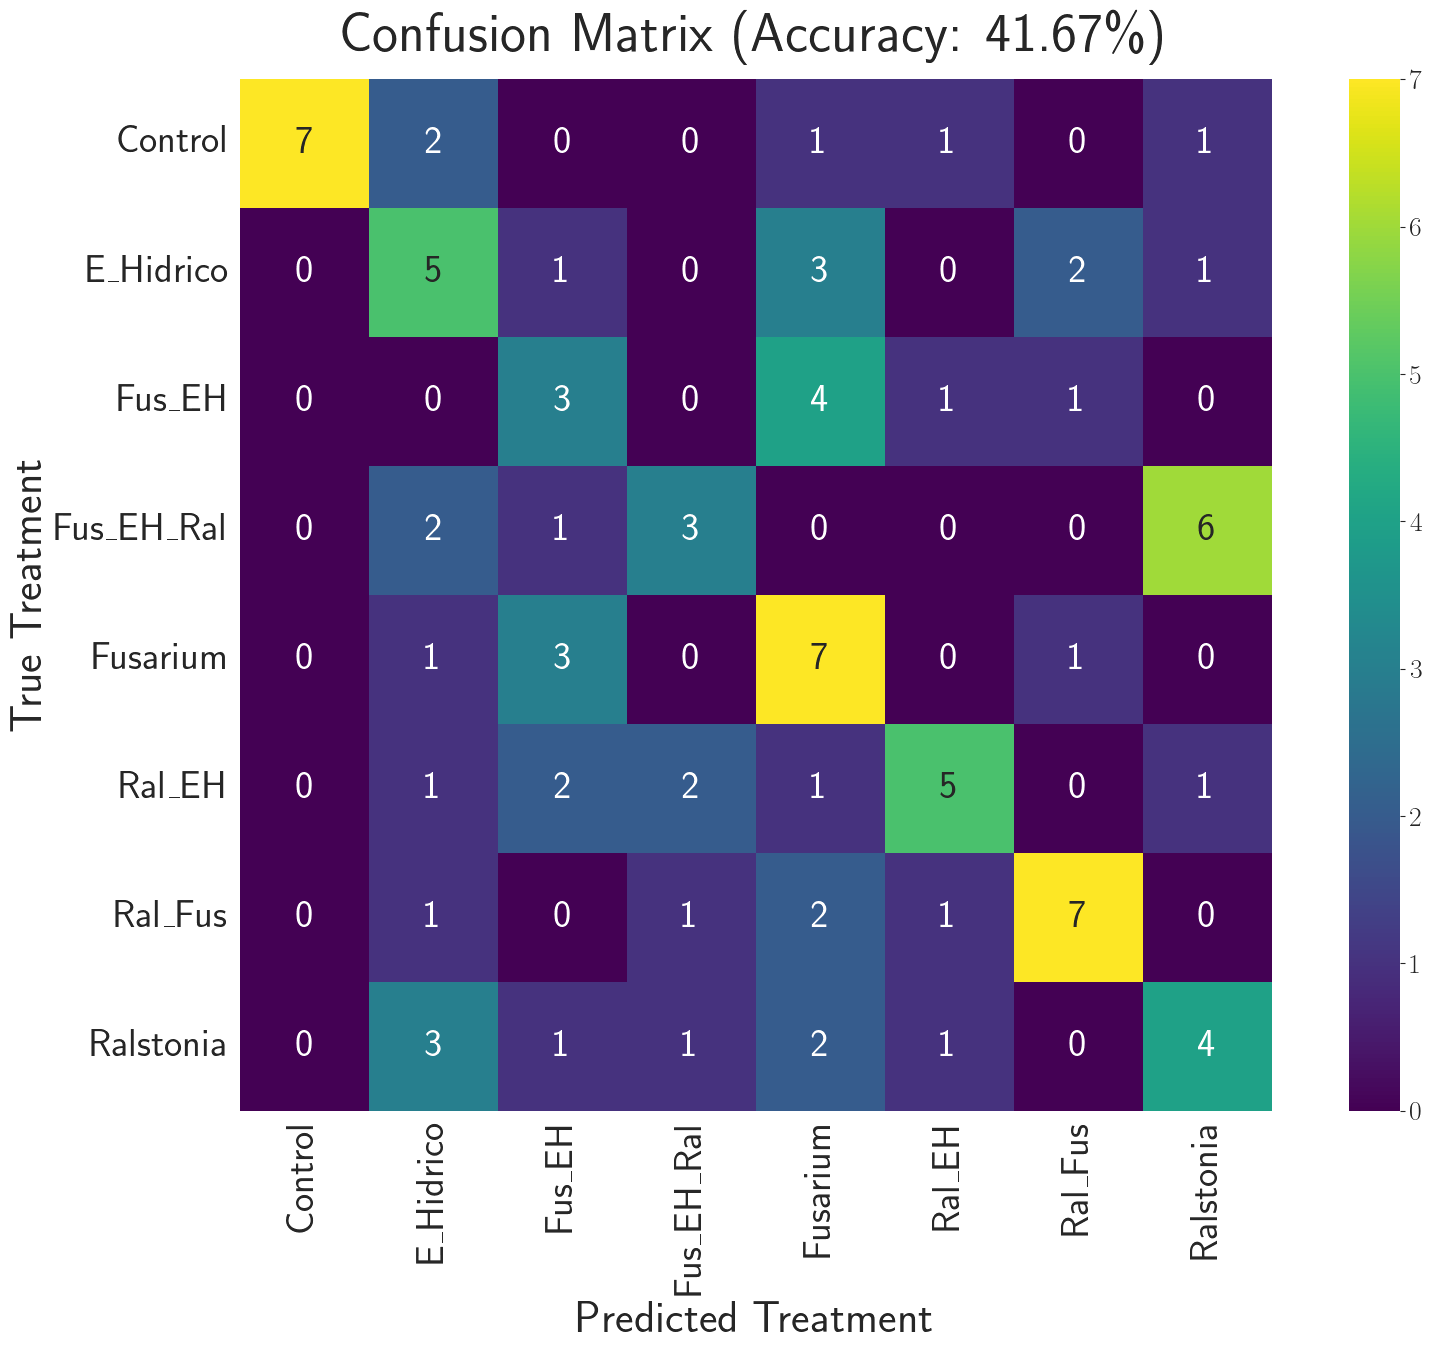

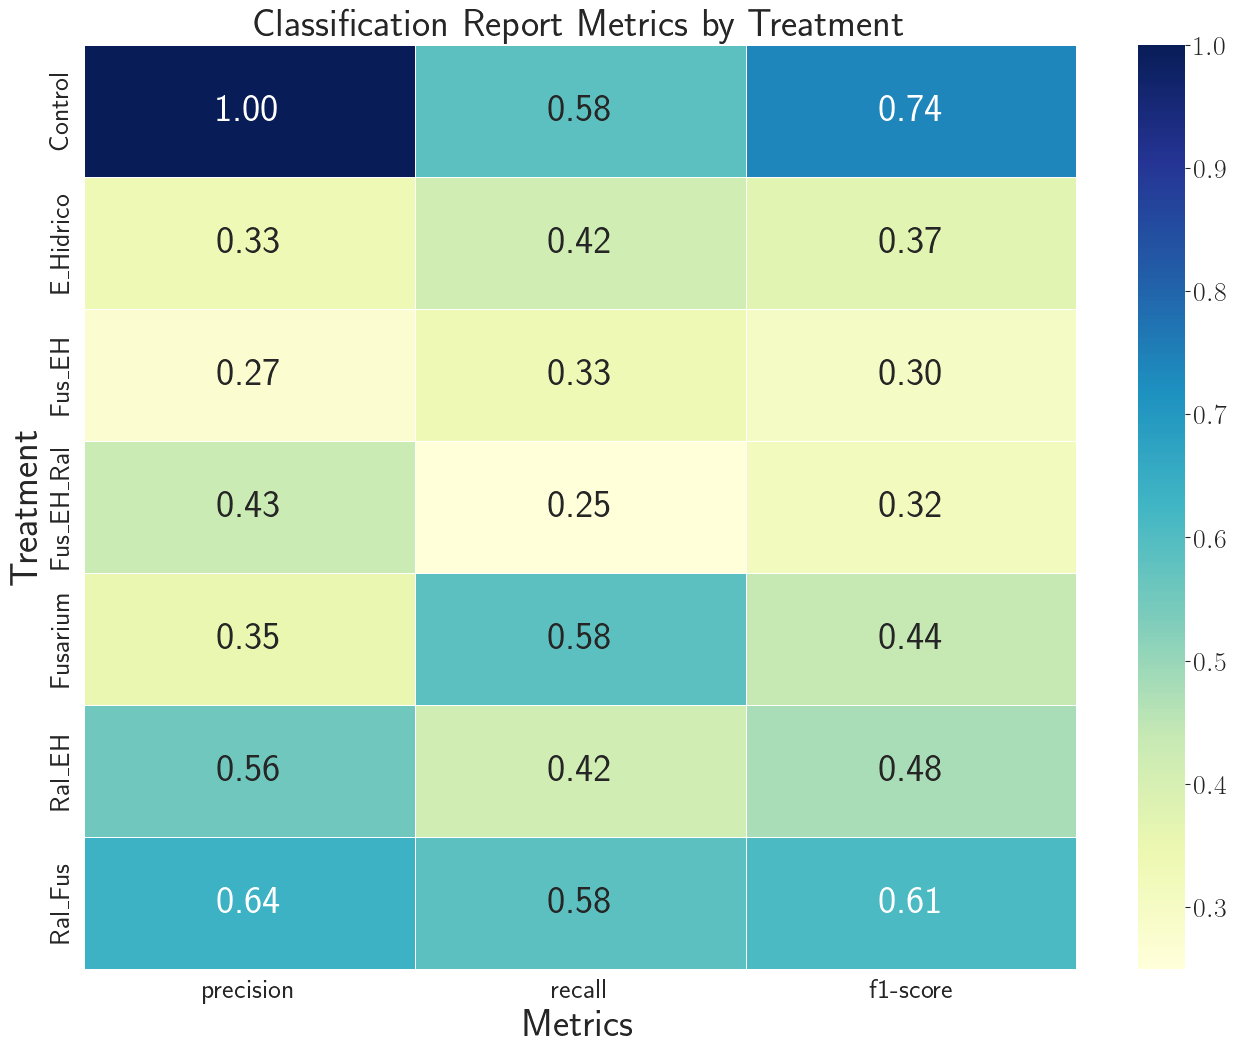

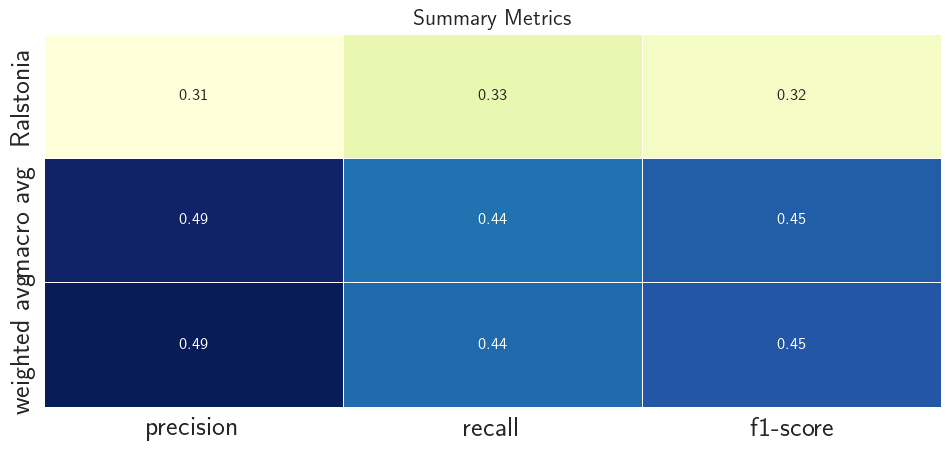

Overall model accuracy: 44.09%

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.58      0.74        12
   E_Hidrico       0.33      0.42      0.37        12
      Fus_EH       0.27      0.33      0.30         9
  Fus_EH_Ral       0.43      0.25      0.32        12
    Fusarium       0.35      0.58      0.44        12
      Ral_EH       0.56      0.42      0.48        12
     Ral_Fus       0.64      0.58      0.61        12
   Ralstonia       0.31      0.33      0.32        12

    accuracy                           0.44        93
   macro avg       0.49      0.44      0.45        93
weighted avg       0.49      0.44      0.45        93



In [5]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(18, 14))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create heatmap directly with seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=labels, yticklabels=labels,
            cbar=True, square=True, annot_kws={'size': 28})

plt.title(f'Confusion Matrix (Accuracy: 41.67\%)', fontsize=40, pad=20)
plt.xlabel('Predicted Treatment', fontsize=32)
plt.ylabel('True Treatment', fontsize=32)
plt.xticks(rotation=90, fontsize=28)
plt.yticks(rotation=0, fontsize=28)

plt.tight_layout()
plt.show()



# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(16, 12))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 28})
plt.title('Classification Report Metrics by Treatment', fontsize=28)
plt.xlabel('Metrics', fontsize=28)
plt.ylabel('Treatment', fontsize=28)



# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### SVM

In [6]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 30, 40],
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': ['balanced', None]
}

pipeline = Pipeline([    
    ('pca', PCA()),                   
    ('svm', SVC())  
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='balanced_accuracy')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pca', PCA()), ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 10, 15, 20, 30, 40],
                         'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__class_weight': ['balanced', None],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='balanced_accuracy', verbose=1)

In [7]:
print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"\nAccuracy on the test set: {accuracy:.4f}")

y_pred = best_model.predict(X_test)

Best cross-validation score (Accuracy): 0.5732
Best parameters found:
{'pca__n_components': 40, 'svm__C': 100, 'svm__class_weight': None, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Accuracy on the test set: 0.5484


<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ricar\AppData\Local\Temp\ipykernel_29012\1640016487.py:13: SyntaxWarning: invalid escape sequence '\%'
  plt.title(f'Confusion Matrix (Accuracy: 44.09\%)', fontsize=40, pad=20)


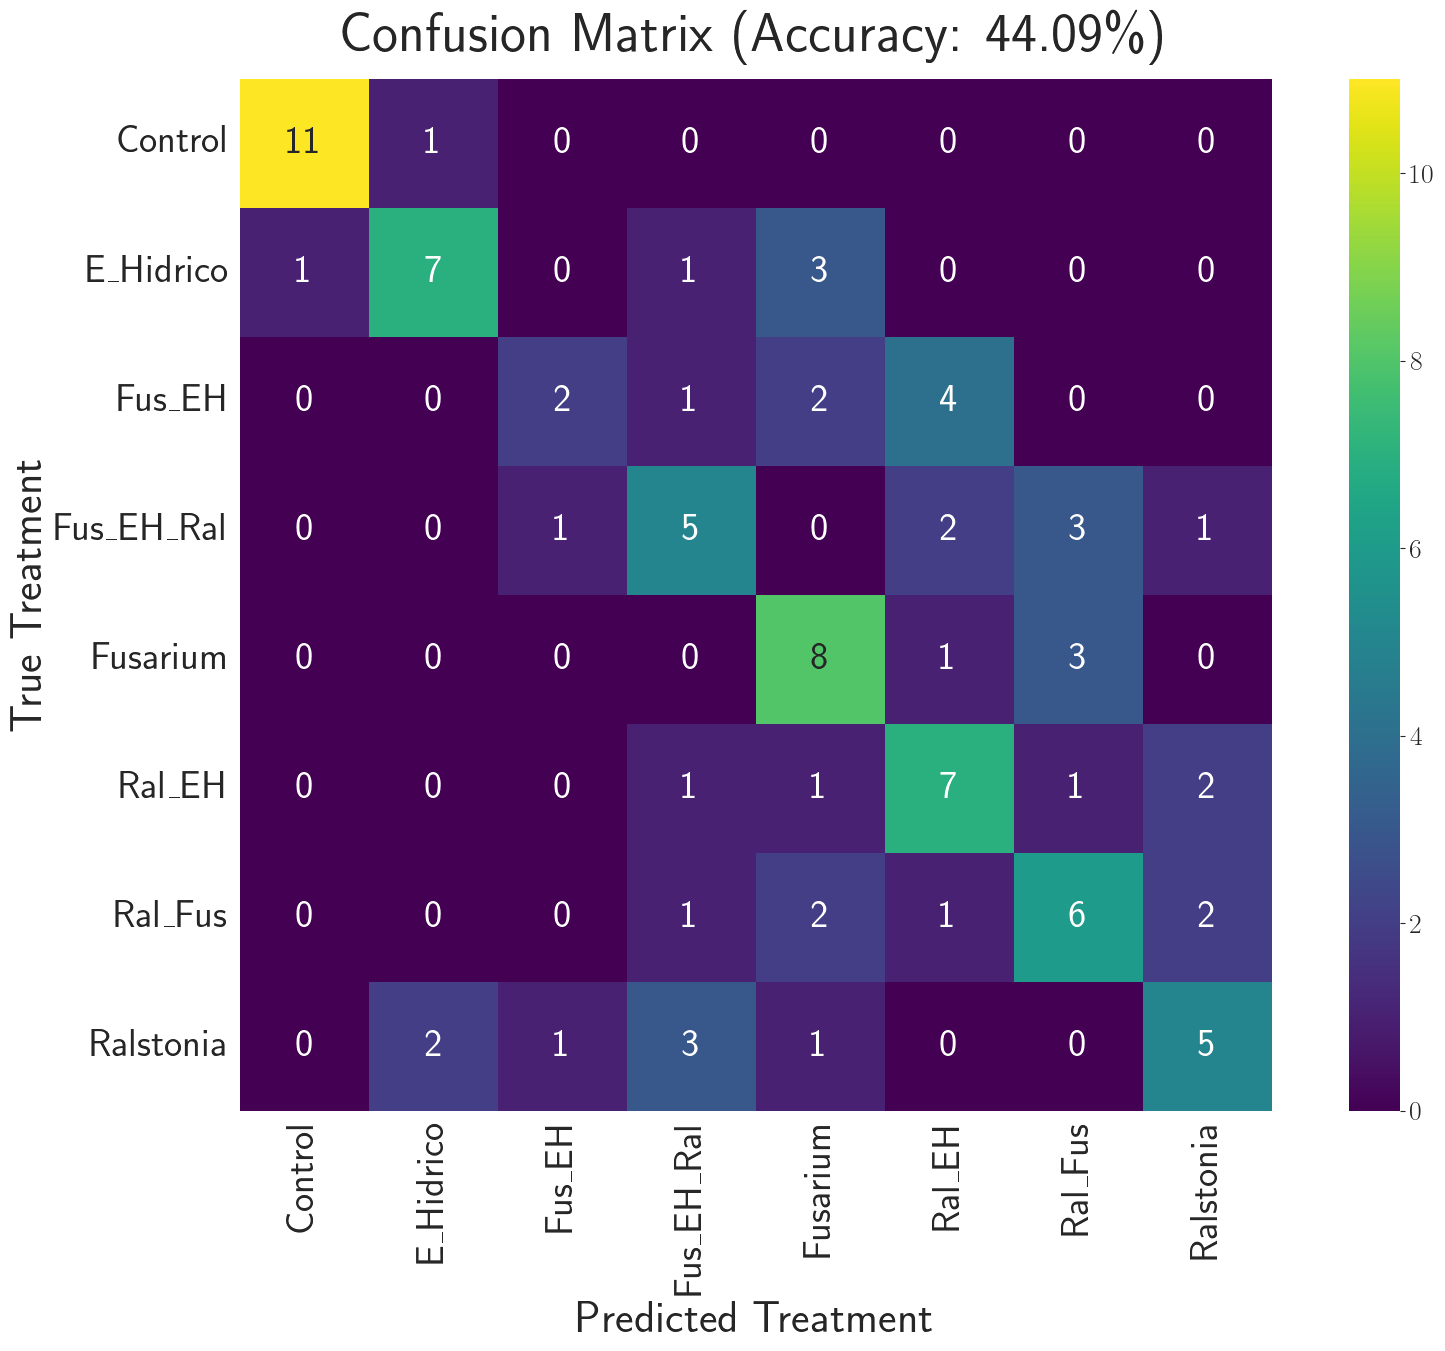

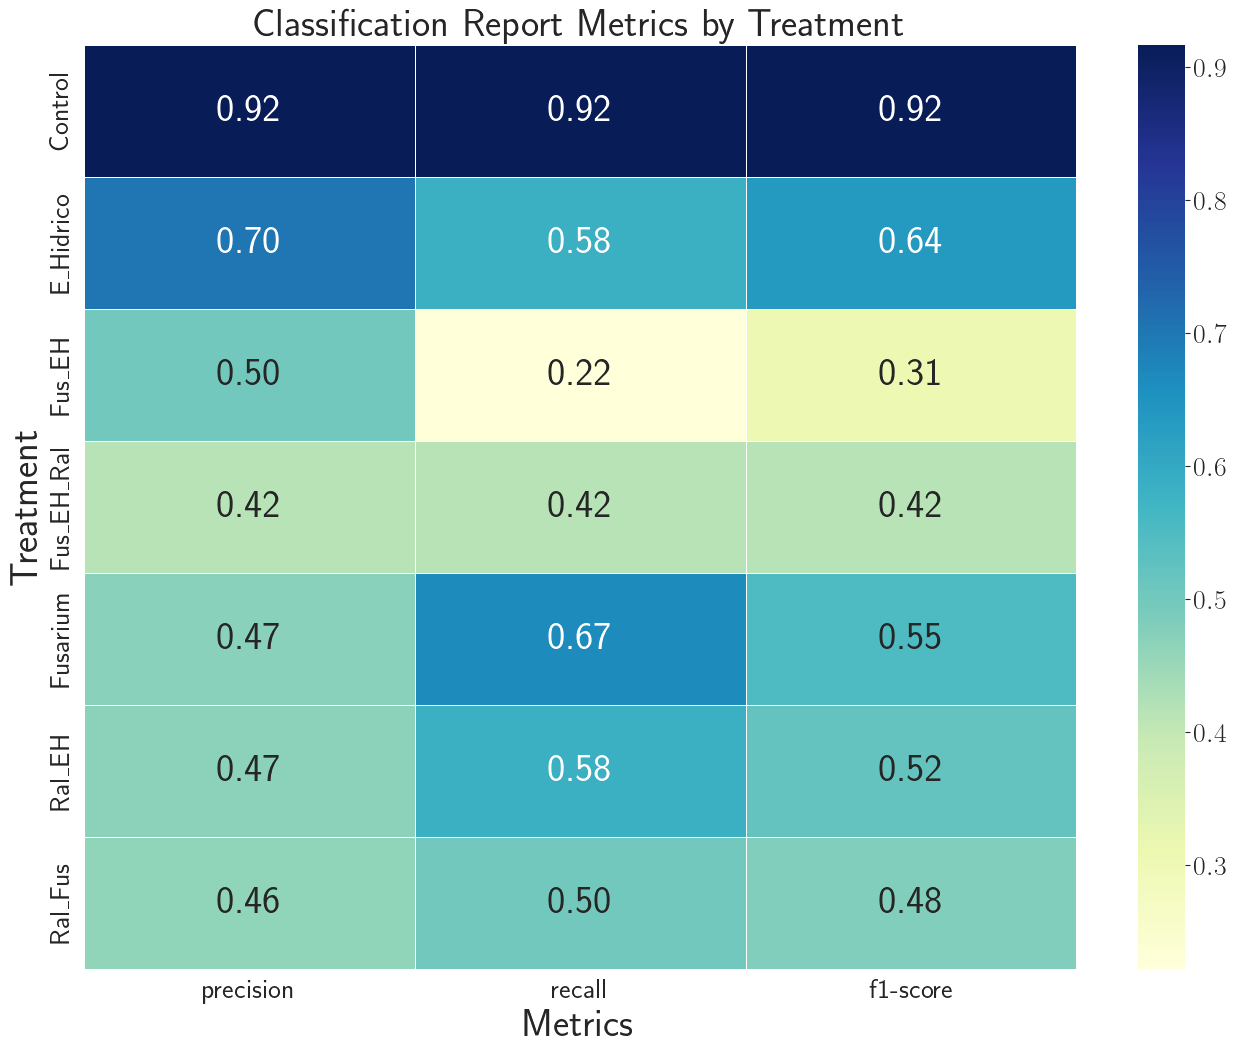

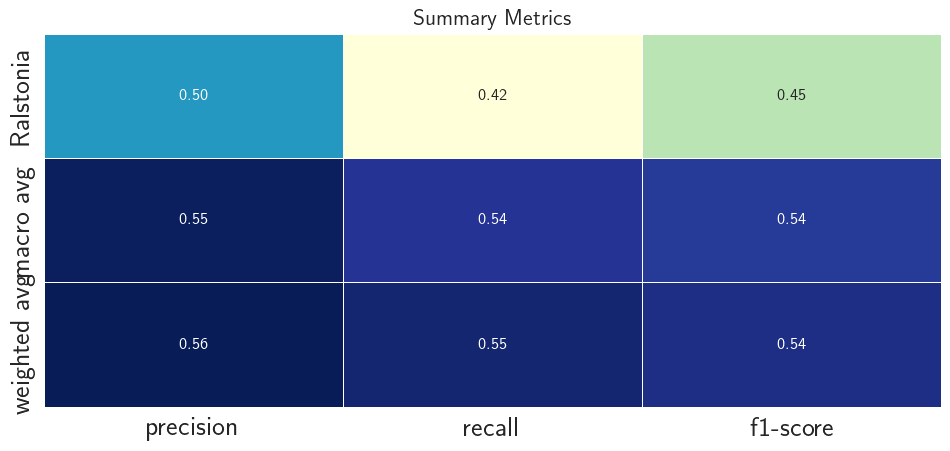

Overall model accuracy: 54.84%

Classification Report:
              precision    recall  f1-score   support

     Control       0.92      0.92      0.92        12
   E_Hidrico       0.70      0.58      0.64        12
      Fus_EH       0.50      0.22      0.31         9
  Fus_EH_Ral       0.42      0.42      0.42        12
    Fusarium       0.47      0.67      0.55        12
      Ral_EH       0.47      0.58      0.52        12
     Ral_Fus       0.46      0.50      0.48        12
   Ralstonia       0.50      0.42      0.45        12

    accuracy                           0.55        93
   macro avg       0.55      0.54      0.54        93
weighted avg       0.56      0.55      0.54        93



In [8]:
# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(18, 14))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = sorted(df['Tratamiento'].unique())

# Create heatmap directly with seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=labels, yticklabels=labels,
            cbar=True, square=True, annot_kws={'size': 28})

plt.title(f'Confusion Matrix (Accuracy: 44.09\%)', fontsize=40, pad=20)
plt.xlabel('Predicted Treatment', fontsize=32)
plt.ylabel('True Treatment', fontsize=32)
plt.xticks(rotation=90, fontsize=28)
plt.yticks(rotation=0, fontsize=28)

plt.tight_layout()
plt.show()



# ---------- PLOT 2: CLASSIFICATION REPORT ----------
plt.figure(figsize=(16, 12))

# Enhanced classification report visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', errors='ignore')  # Remove the accuracy row

# Create heatmap for classification metrics
ax = sns.heatmap(report_df.iloc[:-3, :3], annot=True, cmap='YlGnBu', fmt='.2f', 
        linewidths=0.5, cbar=True, annot_kws={"size": 28})
plt.title('Classification Report Metrics by Treatment', fontsize=28)
plt.xlabel('Metrics', fontsize=28)
plt.ylabel('Treatment', fontsize=28)



# Add the summary metrics at the bottom
summary_df = report_df.iloc[-3:, :3]
plt.figure(figsize=(10, 5))
sns.heatmap(summary_df, annot=True, cmap='YlGnBu', fmt='.2f',
           linewidths=0.5, cbar=False, annot_kws={"size": 12})
plt.title('Summary Metrics', fontsize=16)

plt.tight_layout()
plt.show()

# Print additional performance details
print(f"Overall model accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### MLP (Multi Layer Perceptron)

In [9]:
pca = PCA(n_components=40)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Encode categorical labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(40,)))  # 40 PCA components
    
    # Add between 1-3 hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])
            )
        )
        
        # Optional BatchNormalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(layers.BatchNormalization())
            
        # Dropout rate
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # Try 50 different configurations  
    max_trials=50,  
    # Run each trial twice to reduce variance
    executions_per_trial=2,  
    directory='mlp_tuning',
    project_name='pca_mlp'
)

# Early stopping
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start the search
tuner.search(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[stop_early]
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with full dataset
history = best_model.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[stop_early]
)

#Evaluate the best model
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)



Trial 50 Complete [00h 00m 08s]
val_accuracy: 0.257485032081604

Best val_accuracy So Far: 0.796407163143158
Total elapsed time: 00h 16m 20s
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2361 - loss: 1.9573 - val_accuracy: 0.2455 - val_loss: 1.9027
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3068 - loss: 1.8031 - val_accuracy: 0.3533 - val_loss: 1.7153
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3639 - loss: 1.6710 - val_accuracy: 0.4072 - val_loss: 1.6381
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3850 - loss: 1.5499 - val_accuracy: 0.3713 - val_loss: 1.5421
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4541 - loss: 1.4056 - val_accuracy: 0.3892 - val_loss: 1.4995
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5113 - loss: 1.2727 - val_accuracy: 0.4192 - val_loss: 1.4106
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5489 - loss: 1.2139 - val_accur

In [10]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")



Best Hyperparameters:
num_layers: 3
units_0: 448
activation_0: elu
batch_norm_0: False
dropout_0: 0.1
learning_rate: 0.0023227311360666802
units_1: 160
activation_1: tanh
batch_norm_1: False
dropout_1: 0.1
units_2: 96
activation_2: tanh
batch_norm_2: False
dropout_2: 0.0


<>:19: SyntaxWarning: invalid escape sequence '\%'
<>:19: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ricar\AppData\Local\Temp\ipykernel_29012\1888353526.py:19: SyntaxWarning: invalid escape sequence '\%'
  plt.title(f'MLP Confusion Matrix (Accuracy: 72.04\%)', fontsize=40, pad=20)


Best MLP Accuracy: 0.7204

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.92      0.96        12
   E_Hidrico       0.92      1.00      0.96        12
      Fus_EH       0.75      0.67      0.71         9
  Fus_EH_Ral       0.50      0.50      0.50        12
    Fusarium       0.89      0.67      0.76        12
      Ral_EH       0.80      0.67      0.73        12
     Ral_Fus       0.44      0.67      0.53        12
   Ralstonia       0.67      0.67      0.67        12

    accuracy                           0.72        93
   macro avg       0.75      0.72      0.73        93
weighted avg       0.75      0.72      0.73        93



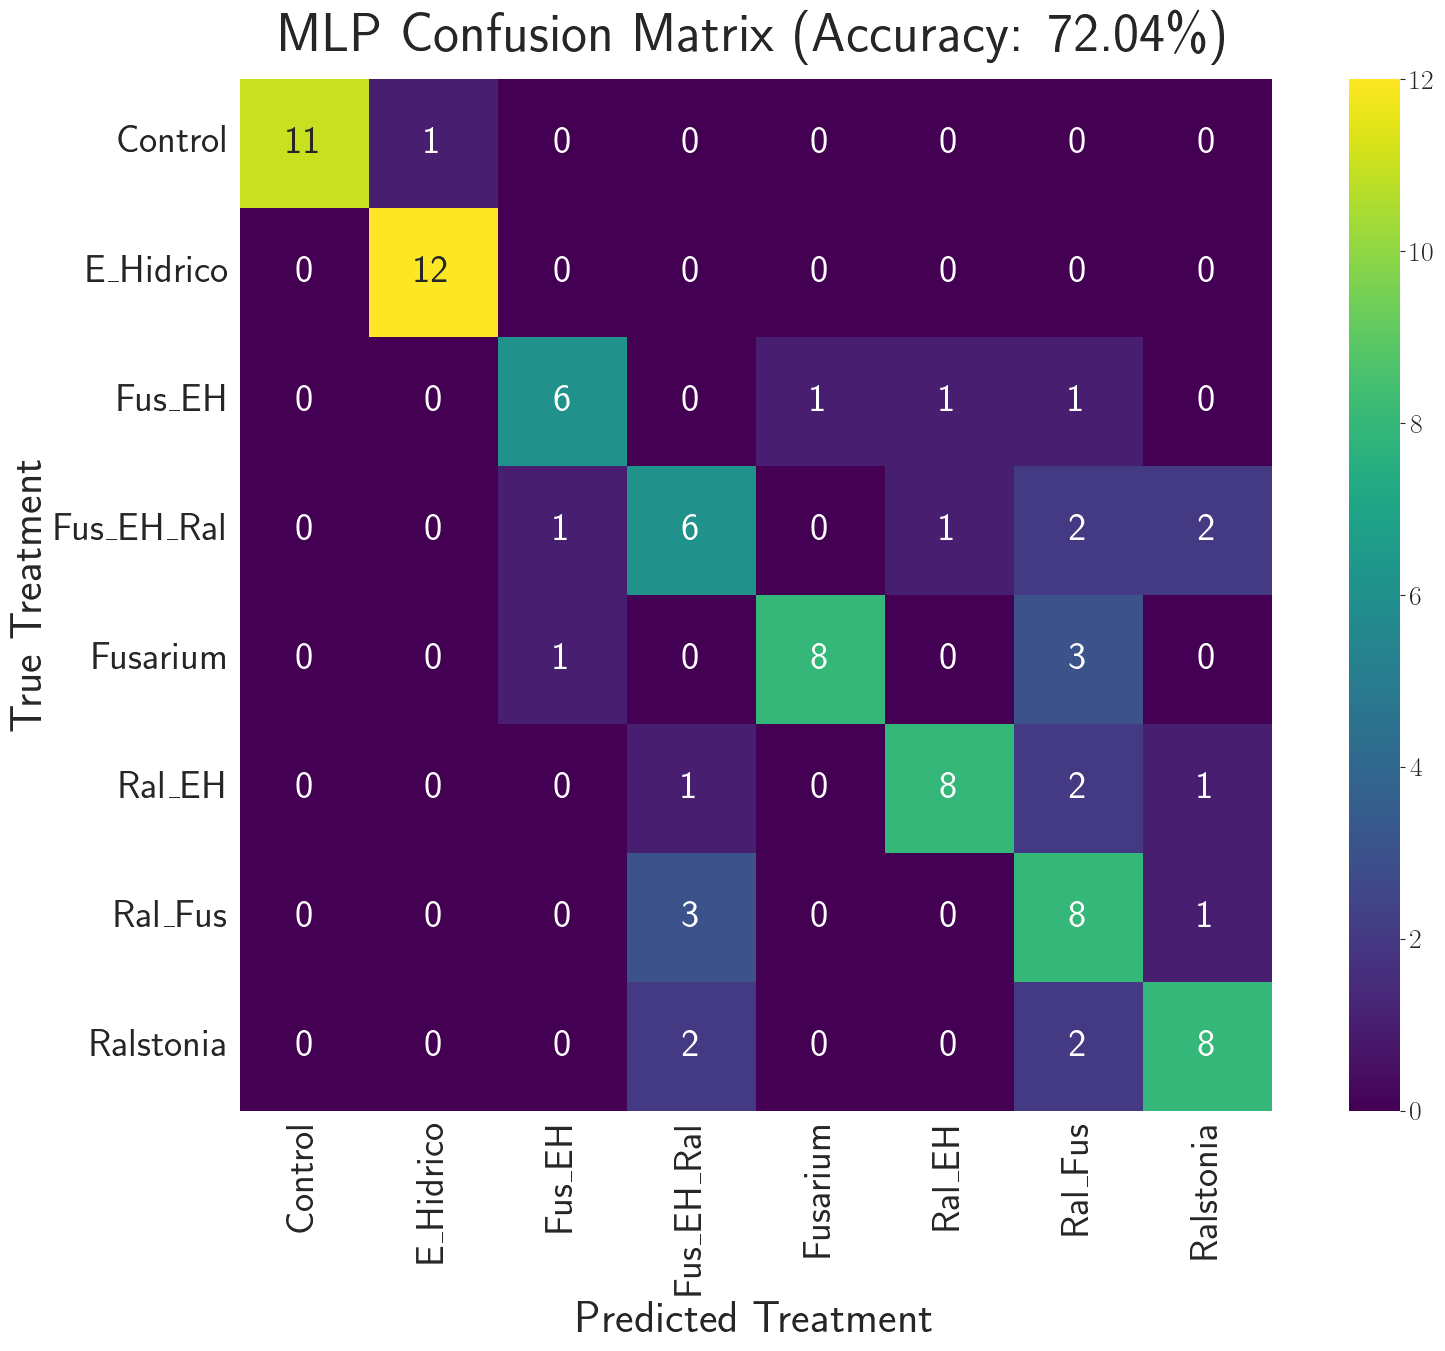

In [13]:
# Print results
print(f"Best MLP Accuracy: {accuracy_score(y_test, y_pred_labels):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))


# ---------- PLOT 1: CONFUSION MATRIX ----------
plt.figure(figsize=(18, 14))

# Enhanced confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_labels)
labels = sorted(df['Tratamiento'].unique())

# Create heatmap directly with seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=labels, yticklabels=labels,
            cbar=True, square=True, annot_kws={'size': 28})

plt.title(f'MLP Confusion Matrix (Accuracy: 72.04\%)', fontsize=40, pad=20)
plt.xlabel('Predicted Treatment', fontsize=32)
plt.ylabel('True Treatment', fontsize=32)
plt.xticks(rotation=90, fontsize=28)
plt.yticks(rotation=0, fontsize=28)

plt.tight_layout()
plt.show()